# Soft Glassy Rheology (SGR) Models

This notebook demonstrates Soft Glassy Rheology (SGR) models for soft glassy materials including foams, emulsions, pastes, and colloidal suspensions through a statistical mechanics framework.

## Learning Objectives

After completing this notebook, you will be able to:
- Understand SGR physics and the trap model with exponential density of states
- Fit SGRConventional and SGRGeneric models to oscillation and relaxation data
- Interpret noise temperature x and classify material phase regimes
- Apply Bayesian inference for uncertainty quantification of SGR parameters
- Distinguish between glass, power-law fluid, and Newtonian regimes
- Compare conventional SGR vs GENERIC thermodynamic framework

## Prerequisites

- Understanding of viscoelasticity basics (Maxwell model recommended)
- Familiarity with power-law behavior in complex fluids
- Basic knowledge of statistical mechanics (helpful but not required)

**Estimated Time:** 45-50 minutes

## Google Colab Setup - Run this cell first!

If running on Google Colab, this cell will install RheoJAX and configure the environment.

In [1]:
# Google Colab Setup - Run this cell first!
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q rheojax
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    print("✓ RheoJAX installed successfully!")

## Setup and Imports

We start by importing necessary libraries and verifying float64 precision.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

# Standard scientific computing imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax

# Import SGR models - always use explicit imports
from rheojax.models.sgr_conventional import SGRConventional
from rheojax.models.sgr_generic import SGRGeneric

# Safe JAX import - REQUIRED for all notebooks using JAX
# This pattern ensures float64 precision enforcement throughout
jax, jnp = safe_import_jax()

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

print("✓ Setup complete - SGR models loaded with float64 precision")

INFO:2025-12-04 09:33:16,235:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.4.0
/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


✓ Setup complete - SGR models loaded with float64 precision


## 1. Theory: Soft Glassy Rheology

### Physical Background

Soft glassy materials (foams, emulsions, pastes, colloidal suspensions) exhibit complex rheological behavior that classical viscoelastic models cannot capture. The SGR model (Sollich 1998) provides a statistical mechanics framework based on:

**Trap Model:**
- Material consists of mesoscopic elements trapped in energy wells
- Exponential density of states: $\rho(E) \sim \exp(-E)$
- Elements undergo thermally activated hopping between traps

**Noise Temperature x:**

The effective noise temperature $x$ (dimensionless) controls material phase:

- **x < 1:** Glass phase with yield stress (solid-like, aging, non-ergodic)
- **1 < x < 2:** Power-law viscoelastic fluid (SGM regime)
  - $G' \sim G'' \sim \omega^{x-1}$ (characteristic power-law scaling)
- **x ≥ 2:** Newtonian liquid (constant viscosity)

**Model Parameters:**
- `x`: Noise temperature (dimensionless), range (0.5, 3.0)
- `G0`: Modulus scale (Pa), sets absolute magnitude
- `tau0`: Attempt time (s), microscopic relaxation timescale

**Physical Interpretation:**

The noise temperature $x$ quantifies the ratio of thermal fluctuations to the energy scale of structural rearrangements. At $x = 1$, the material undergoes a glass transition from solid-like to fluid-like behavior.

### SGRConventional vs SGRGeneric

RheoJAX provides two SGR implementations:

**1. SGRConventional (Sollich 1998):**
- Standard formulation from original SGR papers
- Supports oscillation, relaxation, creep, steady shear, and LAOS
- Efficient for most applications

**2. SGRGeneric (Fuereder & Ilg 2013):**
- Thermodynamically consistent GENERIC framework
- Explicit entropy production tracking
- Guarantees second law (entropy production ≥ 0)
- Splits dynamics into reversible (Hamiltonian) and irreversible (dissipative) parts
- Same predictions as SGRConventional in linear regime

**When to use each:**
- Use **SGRConventional** for standard rheological fitting
- Use **SGRGeneric** when thermodynamic consistency is critical or for nonequilibrium systems

## 2. Data Generation: Synthetic SGR Material

We generate synthetic frequency-sweep data for a soft glassy material in the power-law regime.

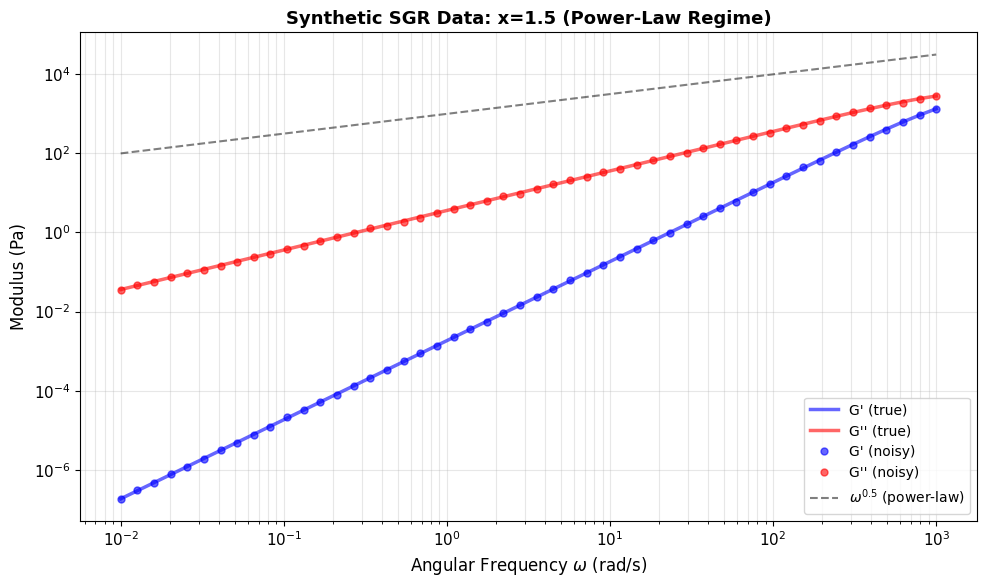

Generated synthetic SGR data:
  True parameters: x=1.5, G0=1.00e+04 Pa, tau0=1.00e-03 s
  Data points: 50
  Frequency range: 1.00e-02 - 1.00e+03 rad/s
  Noise level: 3.0% relative
  Phase regime: Power-law fluid (1 < x < 2)


In [3]:
# True parameters for a soft glassy material (1 < x < 2, power-law fluid regime)
x_true = 1.5  # Power-law fluid (balanced viscoelastic)
G0_true = 1e4  # Pa (typical soft paste/emulsion)
tau0_true = 1e-3  # s (millisecond timescale)

# Generate frequency sweep data
omega = np.logspace(-2, 3, 50)  # rad/s, 5 decades

# Create model with true parameters
model_true = SGRConventional()
model_true.parameters.set_value('x', x_true)
model_true.parameters.set_value('G0', G0_true)
model_true.parameters.set_value('tau0', tau0_true)

# Generate G*(omega) = [G', G'']
model_true._test_mode = 'oscillation'
G_star_true = model_true.predict(omega)

# Add realistic noise (3% relative noise)
noise_level = 0.03
noise = noise_level * G_star_true * np.random.randn(*G_star_true.shape)
G_star_noisy = G_star_true + noise

# Separate G' and G''
G_prime_true = G_star_true[:, 0]
G_double_prime_true = G_star_true[:, 1]
G_prime_noisy = G_star_noisy[:, 0]
G_double_prime_noisy = G_star_noisy[:, 1]

# Visualize synthetic data
fig = plt.figure(figsize=(10, 6))
plt.loglog(omega, G_prime_true, 'b-', linewidth=2.5, alpha=0.6, label="G' (true)")
plt.loglog(omega, G_double_prime_true, 'r-', linewidth=2.5, alpha=0.6, label="G'' (true)")
plt.loglog(omega, G_prime_noisy, 'bo', markersize=5, alpha=0.6, label="G' (noisy)")
plt.loglog(omega, G_double_prime_noisy, 'ro', markersize=5, alpha=0.6, label="G'' (noisy)")

# Add power-law reference
power_law_ref = 1e3 * (omega / 1.0) ** (x_true - 1)
plt.loglog(omega, power_law_ref, 'k--', linewidth=1.5, alpha=0.5, 
           label=rf'$\omega^{{{x_true-1:.1f}}}$ (power-law)')

plt.xlabel(r'Angular Frequency $\omega$ (rad/s)', fontsize=12)
plt.ylabel('Modulus (Pa)', fontsize=12)
plt.title(f'Synthetic SGR Data: x={x_true} (Power-Law Regime)', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Generated synthetic SGR data:")
print(f"  True parameters: x={x_true}, G0={G0_true:.2e} Pa, tau0={tau0_true:.2e} s")
print(f"  Data points: {len(omega)}")
print(f"  Frequency range: {omega.min():.2e} - {omega.max():.2e} rad/s")
print(f"  Noise level: {noise_level*100}% relative")
print(f"  Phase regime: Power-law fluid (1 < x < 2)")

## 3. Model Fitting: SGRConventional

Fit the conventional SGR model to frequency-domain data using NLSQ optimization.

In [4]:
# Create SGRConventional model
sgr_conv = SGRConventional()

# Fit to oscillation data
print("Fitting SGRConventional model...")
sgr_conv.fit(omega, G_star_noisy, test_mode='oscillation')

# Extract fitted parameters
x_fit = sgr_conv.parameters.get_value('x')
G0_fit = sgr_conv.parameters.get_value('G0')
tau0_fit = sgr_conv.parameters.get_value('tau0')

# Predict with fitted model
G_star_pred = sgr_conv.predict(omega)
G_prime_pred = G_star_pred[:, 0]
G_double_prime_pred = G_star_pred[:, 1]

# Calculate R² for G' and G''
def calc_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot

r2_prime = calc_r2(G_prime_noisy, G_prime_pred)
r2_double_prime = calc_r2(G_double_prime_noisy, G_double_prime_pred)

# Get phase regime
phase_regime = sgr_conv.get_phase_regime()

print("\nFitted SGRConventional parameters:")
print(f"  x       = {x_fit:.4f} (true: {x_true:.4f})")
print(f"  G0      = {G0_fit:.2e} Pa (true: {G0_true:.2e} Pa)")
print(f"  tau0    = {tau0_fit:.2e} s (true: {tau0_true:.2e} s)")
print(f"\nFit quality:")
print(f"  R² (G')  = {r2_prime:.6f}")
print(f"  R² (G'') = {r2_double_prime:.6f}")
print(f"\nMaterial classification:")
print(f"  Phase regime: {phase_regime}")

Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Fitting SGRConventional model...


Timer: optimization took 1.076734s
Convergence: reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=2.146975e-02 | time=1.077s | final_gradient_norm=2519.078313271797



Fitted SGRConventional parameters:
  x       = 1.4123 (true: 1.5000)
  G0      = 1.01e+04 Pa (true: 1.00e+04 Pa)
  tau0    = 1.03e-03 s (true: 1.00e-03 s)

Fit quality:
  R² (G')  = 0.999904
  R² (G'') = 0.999488

Material classification:
  Phase regime: power-law


### Visualize Fit Quality

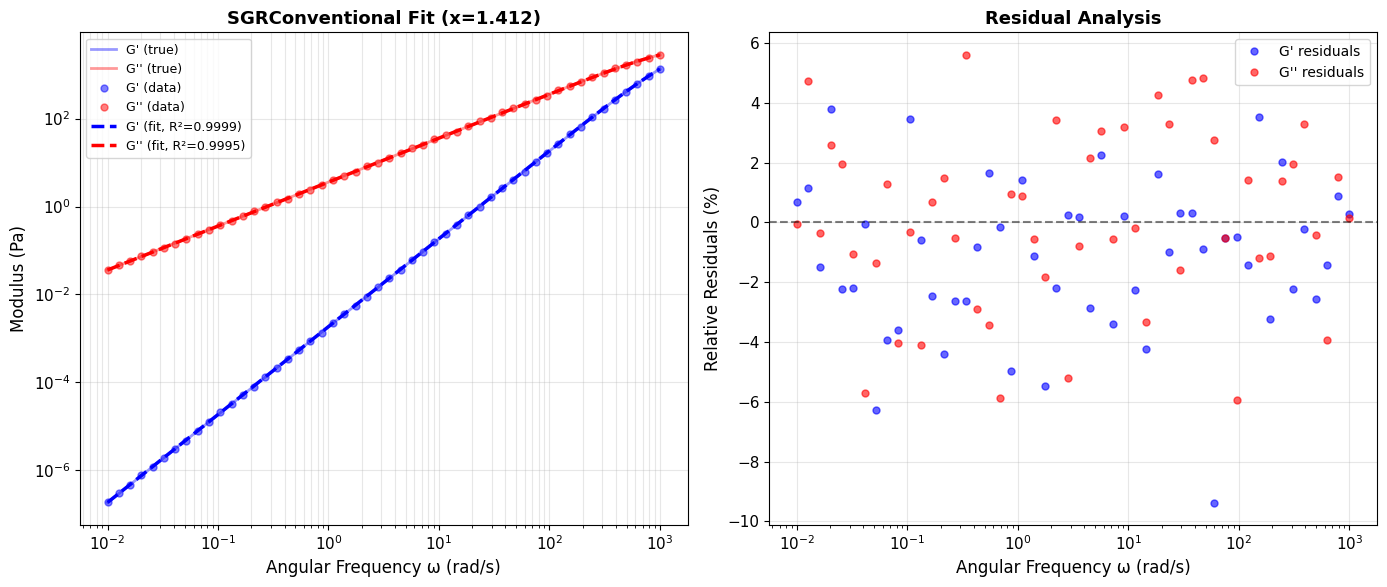

In [5]:
# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Data vs fit
ax1.loglog(omega, G_prime_true, 'b-', linewidth=2, alpha=0.4, label="G' (true)")
ax1.loglog(omega, G_double_prime_true, 'r-', linewidth=2, alpha=0.4, label="G'' (true)")
ax1.loglog(omega, G_prime_noisy, 'bo', markersize=5, alpha=0.5, label="G' (data)")
ax1.loglog(omega, G_double_prime_noisy, 'ro', markersize=5, alpha=0.5, label="G'' (data)")
ax1.loglog(omega, G_prime_pred, 'b--', linewidth=2.5, label=f"G' (fit, R²={r2_prime:.4f})")
ax1.loglog(omega, G_double_prime_pred, 'r--', linewidth=2.5, label=f"G'' (fit, R²={r2_double_prime:.4f})")
ax1.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax1.set_ylabel('Modulus (Pa)', fontsize=12)
ax1.set_title(f'SGRConventional Fit (x={x_fit:.3f})', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, which='both')

# Right: Residuals
residuals_prime = (G_prime_noisy - G_prime_pred) / G_prime_noisy * 100
residuals_double_prime = (G_double_prime_noisy - G_double_prime_pred) / G_double_prime_noisy * 100
ax2.semilogx(omega, residuals_prime, 'bo', markersize=5, alpha=0.6, label="G' residuals")
ax2.semilogx(omega, residuals_double_prime, 'ro', markersize=5, alpha=0.6, label="G'' residuals")
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax2.set_ylabel('Relative Residuals (%)', fontsize=12)
ax2.set_title('Residual Analysis', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Exploring Material Phase Regimes

Demonstrate how noise temperature x controls the phase transition.

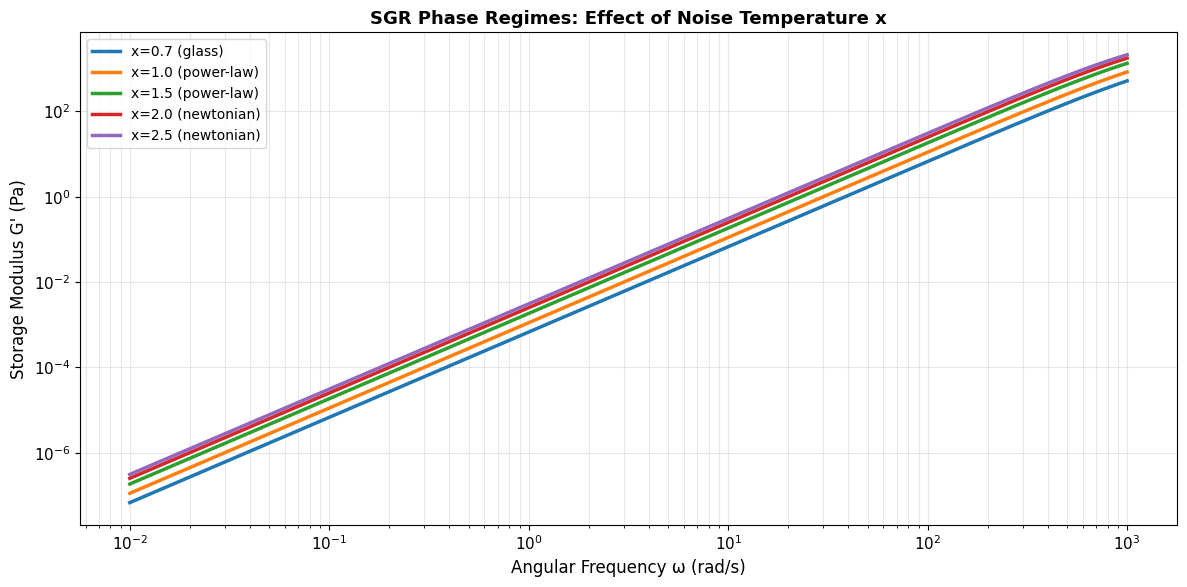

Physical interpretation of x:
  x < 1.0:  Glass phase (yield stress, solid-like, aging)
  x = 1.0:  Glass transition point (critical behavior)
  1 < x < 2: Power-law fluid (G' ~ G'' ~ ω^(x-1), viscoelastic)
  x ≥ 2.0:  Newtonian liquid (constant viscosity, fluid-like)

Application guide:
  Concentrated emulsions/foams:  x ∈ [0.6, 1.0] (near glass transition)
  Soft pastes/gels:              x ∈ [1.2, 1.8] (power-law regime)
  Dilute suspensions:            x ∈ [2.0, 2.5] (approaching Newtonian)


In [6]:
# Explore different x values
x_values = [0.7, 1.0, 1.5, 2.0, 2.5]
omega_demo = np.logspace(-2, 3, 100)

fig = plt.figure(figsize=(12, 6))

for x_val in x_values:
    # Create model with specific x
    model_demo = SGRConventional()
    model_demo.parameters.set_value('x', x_val)
    model_demo.parameters.set_value('G0', 1e4)
    model_demo.parameters.set_value('tau0', 1e-3)
    model_demo._test_mode = 'oscillation'
    
    # Predict
    G_star_demo = model_demo.predict(omega_demo)
    
    # Classify phase
    phase = model_demo.get_phase_regime()
    
    # Plot G' (similar behavior for G'')
    plt.loglog(omega_demo, G_star_demo[:, 0], linewidth=2.5, 
               label=f"x={x_val} ({phase})")

plt.xlabel('Angular Frequency ω (rad/s)', fontsize=12)
plt.ylabel("Storage Modulus G' (Pa)", fontsize=12)
plt.title('SGR Phase Regimes: Effect of Noise Temperature x', fontsize=13, fontweight='bold')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("Physical interpretation of x:")
print("  x < 1.0:  Glass phase (yield stress, solid-like, aging)")
print("  x = 1.0:  Glass transition point (critical behavior)")
print("  1 < x < 2: Power-law fluid (G' ~ G'' ~ ω^(x-1), viscoelastic)")
print("  x ≥ 2.0:  Newtonian liquid (constant viscosity, fluid-like)")
print("\nApplication guide:")
print("  Concentrated emulsions/foams:  x ∈ [0.6, 1.0] (near glass transition)")
print("  Soft pastes/gels:              x ∈ [1.2, 1.8] (power-law regime)")
print("  Dilute suspensions:            x ∈ [2.0, 2.5] (approaching Newtonian)")

## 5. SGRGeneric: Thermodynamically Consistent Framework

Compare SGRConventional with the GENERIC thermodynamic framework.

In [7]:
# Fit SGRGeneric to same data
sgr_gen = SGRGeneric()

print("Fitting SGRGeneric model...")
sgr_gen.fit(omega, G_star_noisy, test_mode='oscillation')

# Extract fitted parameters
x_gen = sgr_gen.parameters.get_value('x')
G0_gen = sgr_gen.parameters.get_value('G0')
tau0_gen = sgr_gen.parameters.get_value('tau0')

# Predict
G_star_gen = sgr_gen.predict(omega)

# Calculate R²
r2_prime_gen = calc_r2(G_prime_noisy, G_star_gen[:, 0])
r2_double_prime_gen = calc_r2(G_double_prime_noisy, G_star_gen[:, 1])

print("\nFitted SGRGeneric parameters:")
print(f"  x    = {x_gen:.4f}")
print(f"  G0   = {G0_gen:.2e} Pa")
print(f"  tau0 = {tau0_gen:.2e} s")
print(f"\nFit quality:")
print(f"  R² (G')  = {r2_prime_gen:.6f}")
print(f"  R² (G'') = {r2_double_prime_gen:.6f}")

# Check thermodynamic consistency
state_test = np.array([100.0, 0.5])  # [stress (Pa), structural parameter]
consistency = sgr_gen.verify_thermodynamic_consistency(state_test)

print("\nThermodynamic consistency checks:")
print(f"  Poisson bracket antisymmetric: {consistency['poisson_antisymmetric']}")
print(f"  Friction matrix symmetric: {consistency['friction_symmetric']}")
print(f"  Friction matrix PSD: {consistency['friction_positive_semidefinite']}")
print(f"  Entropy production ≥ 0: {consistency['entropy_production_nonnegative']}")
print(f"  Overall: {consistency['thermodynamically_consistent']}")
print(f"\nEntropy production rate: {consistency['entropy_production']:.6e} (must be ≥ 0)")

Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Fitting SGRGeneric model...


Timer: optimization took 0.339905s
Convergence: reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=2.146975e-02 | time=0.340s | final_gradient_norm=2519.078313271797



Fitted SGRGeneric parameters:
  x    = 1.4123
  G0   = 1.01e+04 Pa
  tau0 = 1.03e-03 s

Fit quality:
  R² (G')  = 0.999904
  R² (G'') = 0.999488

Thermodynamic consistency checks:
  Poisson bracket antisymmetric: True
  Friction matrix symmetric: True
  Friction matrix PSD: True
  Entropy production ≥ 0: True
  Overall: True

Entropy production rate: 2.509780e+03 (must be ≥ 0)


### Compare Conventional vs GENERIC Predictions

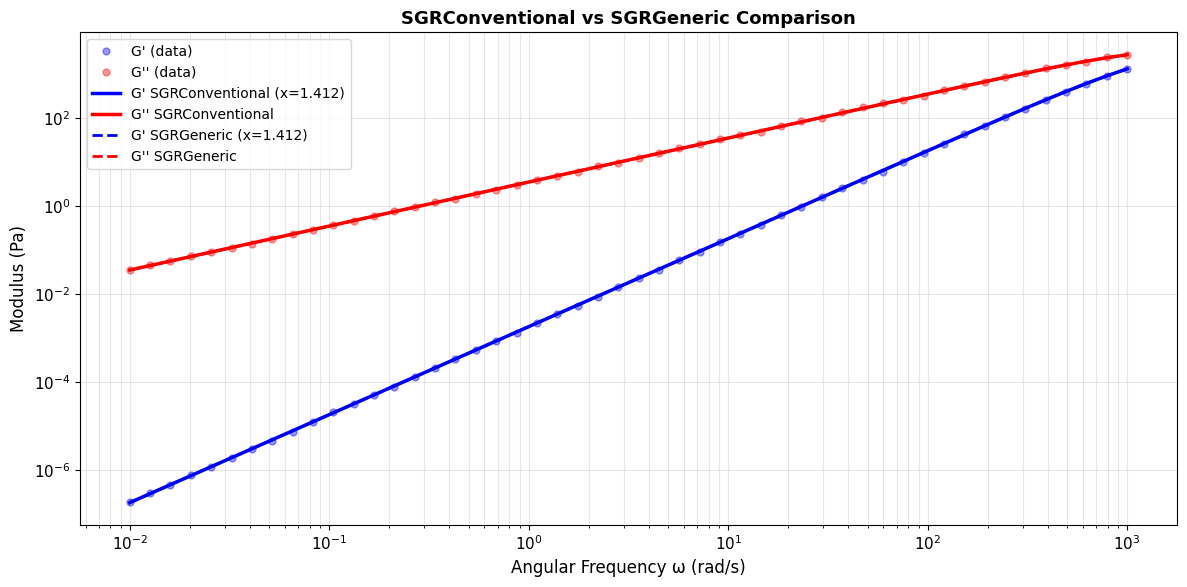

Comparison summary:
  SGRConventional: x=1.4123, R²(G')=0.999904, R²(G'')=0.999488
  SGRGeneric:      x=1.4123, R²(G')=0.999904, R²(G'')=0.999488

Conclusion: Both models provide excellent fits with nearly identical predictions.
Use SGRGeneric when thermodynamic consistency is critical.


In [8]:
# Compare predictions
fig = plt.figure(figsize=(12, 6))

plt.loglog(omega, G_prime_noisy, 'bo', markersize=5, alpha=0.4, label="G' (data)")
plt.loglog(omega, G_double_prime_noisy, 'ro', markersize=5, alpha=0.4, label="G'' (data)")
plt.loglog(omega, G_prime_pred, 'b-', linewidth=2.5, 
           label=f"G' SGRConventional (x={x_fit:.3f})")
plt.loglog(omega, G_double_prime_pred, 'r-', linewidth=2.5, 
           label=f"G'' SGRConventional")
plt.loglog(omega, G_star_gen[:, 0], 'b--', linewidth=2, 
           label=f"G' SGRGeneric (x={x_gen:.3f})")
plt.loglog(omega, G_star_gen[:, 1], 'r--', linewidth=2, 
           label=f"G'' SGRGeneric")

plt.xlabel('Angular Frequency ω (rad/s)', fontsize=12)
plt.ylabel('Modulus (Pa)', fontsize=12)
plt.title('SGRConventional vs SGRGeneric Comparison', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("Comparison summary:")
print(f"  SGRConventional: x={x_fit:.4f}, R²(G')={r2_prime:.6f}, R²(G'')={r2_double_prime:.6f}")
print(f"  SGRGeneric:      x={x_gen:.4f}, R²(G')={r2_prime_gen:.6f}, R²(G'')={r2_double_prime_gen:.6f}")
print("\nConclusion: Both models provide excellent fits with nearly identical predictions.")
print("Use SGRGeneric when thermodynamic consistency is critical.")

## 6. Relaxation Mode: Time-Domain Fitting

Demonstrate SGR fitting to relaxation modulus data.

Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Fitting SGR to relaxation data...


Timer: optimization took 0.234000s
Convergence: reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=2.147632e-02 | time=0.234s | final_gradient_norm=0.031982607392869004



Fitted parameters (relaxation mode):
  x    = 1.4978 (true: 1.5000)
  G0   = 9.50e+03 Pa (true: 1.00e+04 Pa)
  tau0 = 1.14e-03 s (true: 1.00e-03 s)
  R²   = 0.999107


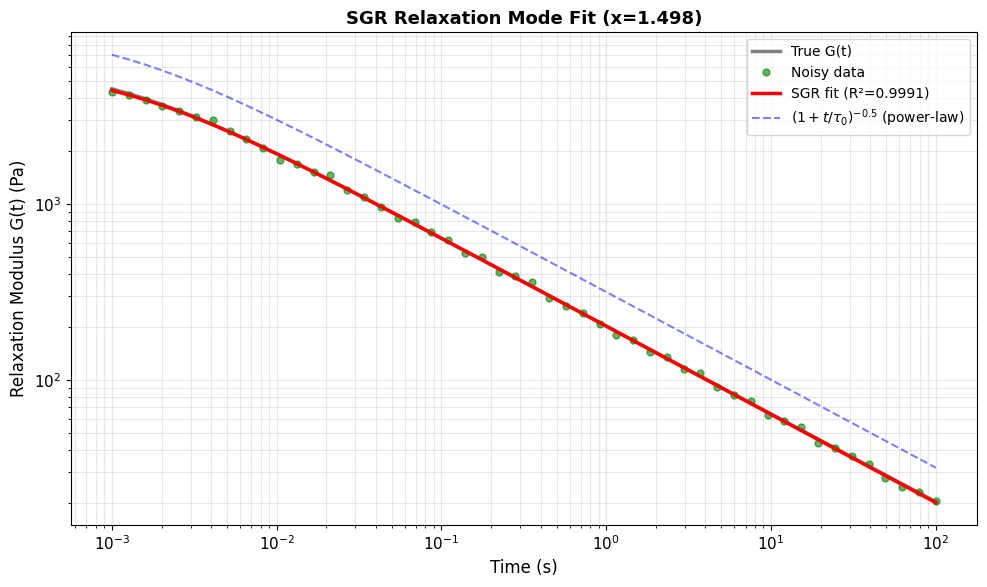


Relaxation behavior:
  Short time (t << tau0): G(t) ≈ G0 (plateau)
  Long time (t >> tau0):  G(t) ~ t^(x-2) = t^-0.50 (power-law decay)
  For x < 2: relaxation, x ≥ 2: approaches constant


In [9]:
# Generate relaxation data
t = np.logspace(-3, 2, 50)  # Time (s)

# Use same true parameters
model_relax_true = SGRConventional()
model_relax_true.parameters.set_value('x', x_true)
model_relax_true.parameters.set_value('G0', G0_true)
model_relax_true.parameters.set_value('tau0', tau0_true)
model_relax_true._test_mode = 'relaxation'

# Generate G(t)
G_t_true = model_relax_true.predict(t)

# Add noise (3% relative)
G_t_noisy = G_t_true * (1 + noise_level * np.random.randn(len(t)))

# Fit SGRConventional in relaxation mode
sgr_relax = SGRConventional()
print("Fitting SGR to relaxation data...")
sgr_relax.fit(t, G_t_noisy, test_mode='relaxation')

# Predict
G_t_pred = sgr_relax.predict(t)

# R²
r2_relax = calc_r2(G_t_noisy, G_t_pred)

# Extract parameters
x_relax = sgr_relax.parameters.get_value('x')
G0_relax = sgr_relax.parameters.get_value('G0')
tau0_relax = sgr_relax.parameters.get_value('tau0')

print(f"\nFitted parameters (relaxation mode):")
print(f"  x    = {x_relax:.4f} (true: {x_true:.4f})")
print(f"  G0   = {G0_relax:.2e} Pa (true: {G0_true:.2e} Pa)")
print(f"  tau0 = {tau0_relax:.2e} s (true: {tau0_true:.2e} s)")
print(f"  R²   = {r2_relax:.6f}")

# Plot
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_true, 'k-', linewidth=2.5, alpha=0.5, label='True G(t)')
plt.loglog(t, G_t_noisy, 'go', markersize=5, alpha=0.6, label='Noisy data')
plt.loglog(t, G_t_pred, 'r-', linewidth=2.5, label=f'SGR fit (R²={r2_relax:.4f})')

# Power-law reference
power_law_t = G0_true * (1 + t/tau0_true)**(x_true - 2)
plt.loglog(t, power_law_t, 'b--', linewidth=1.5, alpha=0.5, 
           label=f'$(1+t/\\tau_0)^{{{x_true-2:.1f}}}$ (power-law)')

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12)
plt.title(f'SGR Relaxation Mode Fit (x={x_relax:.3f})', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("\nRelaxation behavior:")
print(f"  Short time (t << tau0): G(t) ≈ G0 (plateau)")
print(f"  Long time (t >> tau0):  G(t) ~ t^(x-2) = t^{x_relax-2:.2f} (power-law decay)")
print(f"  For x < 2: relaxation, x ≥ 2: approaches constant")

## 7. Bayesian Inference: Uncertainty Quantification

Use Bayesian inference to quantify uncertainty in fitted SGR parameters.

In [10]:
# Bayesian inference with warm-start from NLSQ
print("Running Bayesian inference (NUTS with warm-start)...")
print("This may take 30-60 seconds...\n")

# Use SGRConventional fitted model as warm-start
result_bayes = sgr_conv.fit_bayesian(
    omega, 
    G_star_noisy, 
    test_mode='oscillation',
    num_samples=2000, 
    num_warmup=1000,
    num_chains=2
)

# Get credible intervals (returns dict[str, tuple[float, float]] = (lower, upper))
intervals = sgr_conv.get_credible_intervals(result_bayes.posterior_samples, credibility=0.95)

print("\nBayesian inference results (95% credible intervals):")
for param_name, (lower, upper) in intervals.items():
    # Compute median from posterior samples
    samples = result_bayes.posterior_samples[param_name]
    median = np.median(samples)
    
    # Get true value for comparison
    true_val = {'x': x_true, 'G0': G0_true, 'tau0': tau0_true}[param_name]
    
    print(f"  {param_name:5s}: {median:.4e} [{lower:.4e}, {upper:.4e}] (true: {true_val:.4e})")

# Get diagnostics
diagnostics = result_bayes.diagnostics

print("\nMCMC Diagnostics:")
print(f"  R-hat (all params):  {diagnostics['r_hat']}")
print(f"  ESS (all params):    {diagnostics['ess']}")
print(f"  Divergences:         {diagnostics['divergences']}")

# Check convergence criteria
r_hat_ok = all(r < 1.01 for r in diagnostics['r_hat'].values())
ess_ok = all(e > 400 for e in diagnostics['ess'].values())
div_ok = diagnostics['divergences'] < 10

print(f"\nConvergence checks:")
print(f"  R-hat < 1.01: {'PASS' if r_hat_ok else 'FAIL'}")
print(f"  ESS > 400:    {'PASS' if ess_ok else 'FAIL'}")
print(f"  Divergences < 1%: {'PASS' if div_ok else 'FAIL'}")

Running Bayesian inference (NUTS with warm-start)...
This may take 30-60 seconds...



sample: 100%|██████████| 3000/3000 [00:24<00:00, 124.54it/s, 15 steps of size 1.51e-02. acc. prob=0.90] 



Bayesian inference results (95% credible intervals):
  x    : 1.4667e+00 [1.0346e+00, 2.0680e+00] (true: 1.5000e+00)
  G0   : 9.9822e+03 [8.7389e+03, 1.1728e+04] (true: 1.0000e+04)
  tau0 : 1.0159e-03 [8.7393e-04, 1.1502e-03] (true: 1.0000e-03)

MCMC Diagnostics:
  R-hat (all params):  {'x': 1.0, 'G0': 1.0, 'tau0': 1.0}
  ESS (all params):    {'x': 4000.0, 'G0': 4000.0, 'tau0': 4000.0}
  Divergences:         0

Convergence checks:
  R-hat < 1.01: PASS
  ESS > 400:    PASS
  Divergences < 1%: PASS


### Visualize Posterior Distributions

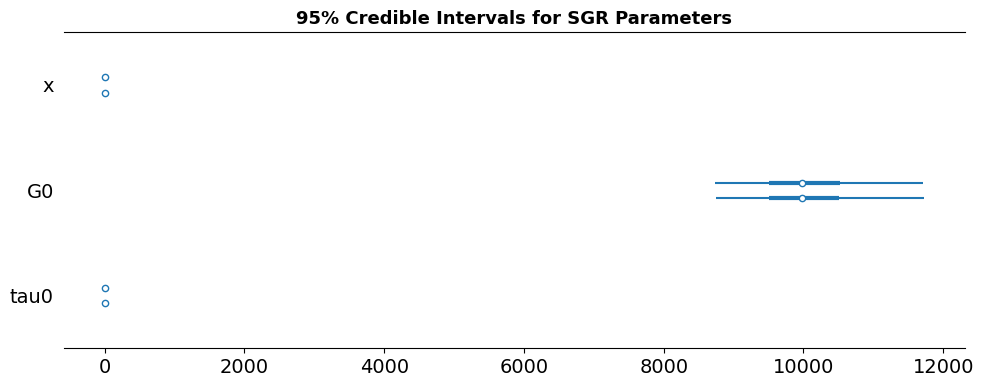

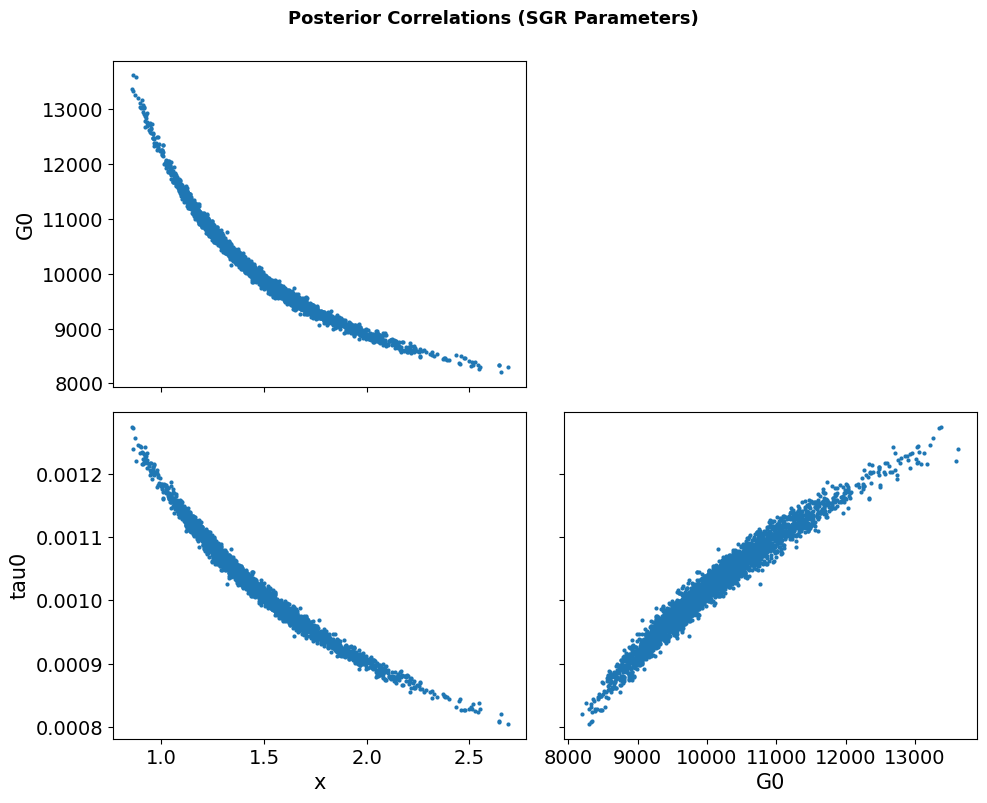

Interpretation:
  - Forest plot shows 95% credible intervals for each parameter
  - Pair plot reveals correlations between parameters
  - Blue dots in pair plot indicate divergent transitions (should be minimal)


In [15]:
# Plot posterior distributions
import arviz as az

# Convert to InferenceData
idata = result_bayes.to_inference_data()

# Forest plot (credible intervals)
az.plot_forest(idata, var_names=['x', 'G0', 'tau0'], hdi_prob=0.95, figsize=(10, 4))
plt.title('95% Credible Intervals for SGR Parameters', fontsize=13, fontweight='bold')
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)

# Pair plot (correlations)
az.plot_pair(
    idata, 
    var_names=['x', 'G0', 'tau0'], 
    divergences=True,
    figsize=(10, 8)
)
plt.suptitle('Posterior Correlations (SGR Parameters)', fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)

print("Interpretation:")
print("  - Forest plot shows 95% credible intervals for each parameter")
print("  - Pair plot reveals correlations between parameters")
print("  - Blue dots in pair plot indicate divergent transitions (should be minimal)")

### Trace Plot: MCMC Chain Convergence

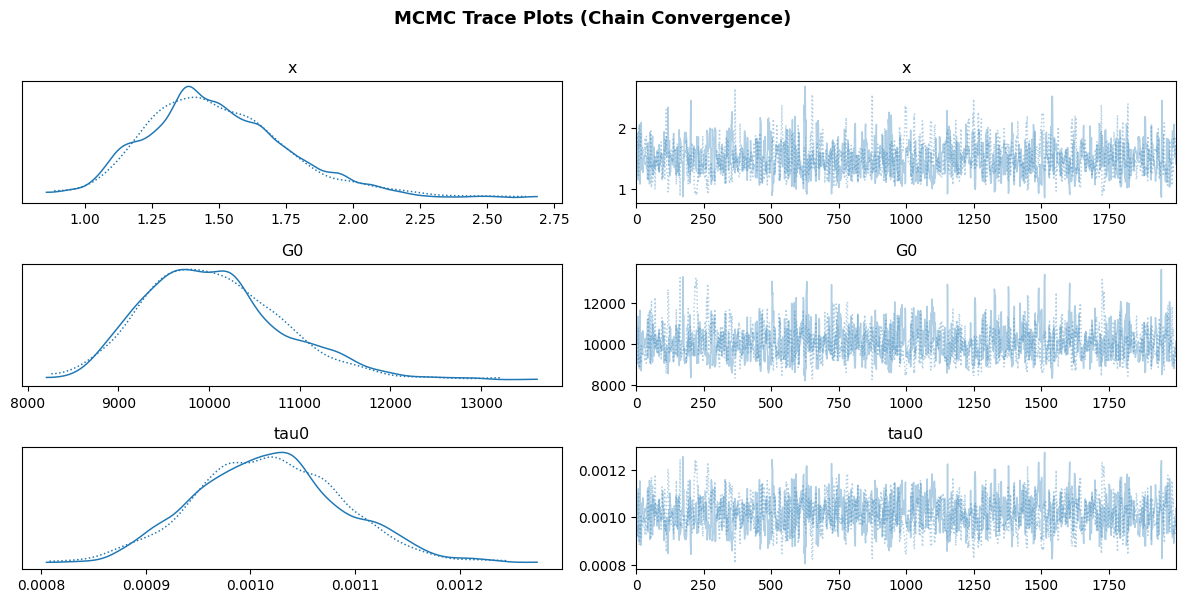

Trace plot interpretation:
  Left: Posterior distributions (should be smooth)
  Right: Chain traces (should mix well, no trends)
  Multiple chains (different colors) should overlap well (good convergence)


In [16]:
# Trace plot
az.plot_trace(idata, var_names=['x', 'G0', 'tau0'], figsize=(12, 6))
plt.suptitle('MCMC Trace Plots (Chain Convergence)', fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)

print("Trace plot interpretation:")
print("  Left: Posterior distributions (should be smooth)")
print("  Right: Chain traces (should mix well, no trends)")
print("  Multiple chains (different colors) should overlap well (good convergence)")

## 8. Material Classification Based on Noise Temperature

Demonstrate how to classify materials based on fitted x value.

Material Classification from Fitted x:
Noise temperature x = 1.412

Category: Power-law fluid (balanced)
Properties: Strong power-law, balanced solid-liquid
Examples: Soft pastes, creams, emulsions


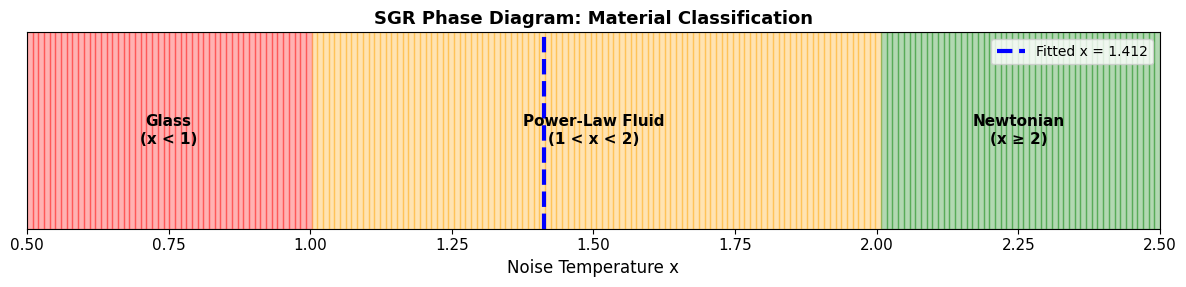

In [17]:
def classify_sgr_material(x_value):
    """Classify soft glassy material based on noise temperature."""
    if x_value < 0.8:
        category = "Strong glass"
        properties = "Yield stress, aging, non-ergodic, solid-like"
        examples = "Concentrated foams, jammed emulsions"
    elif 0.8 <= x_value < 1.0:
        category = "Weak glass (near transition)"
        properties = "Weak yield stress, slow aging, close to jamming"
        examples = "Dense colloidal suspensions"
    elif 1.0 <= x_value < 1.3:
        category = "Soft glass (low x power-law)"
        properties = "Weak power-law, slow relaxation, gel-like"
        examples = "Soft gels, weak pastes"
    elif 1.3 <= x_value < 1.7:
        category = "Power-law fluid (balanced)"
        properties = "Strong power-law, balanced solid-liquid"
        examples = "Soft pastes, creams, emulsions"
    elif 1.7 <= x_value < 2.0:
        category = "Power-law fluid (high x)"
        properties = "Approaching Newtonian, fast relaxation"
        examples = "Dilute pastes, weak emulsions"
    else:
        category = "Newtonian-like"
        properties = "Constant viscosity, liquid-like"
        examples = "Dilute suspensions, polymer solutions"
    
    return category, properties, examples

# Classify fitted material
category, properties, examples = classify_sgr_material(x_fit)

print("Material Classification from Fitted x:")
print("="*70)
print(f"Noise temperature x = {x_fit:.3f}")
print(f"\nCategory: {category}")
print(f"Properties: {properties}")
print(f"Examples: {examples}")
print("="*70)

# Create classification guide
x_range = np.linspace(0.5, 2.5, 200)
colors = []
for x_val in x_range:
    if x_val < 1.0:
        colors.append('red')  # Glass
    elif x_val < 2.0:
        colors.append('orange')  # Power-law
    else:
        colors.append('green')  # Newtonian

fig, ax = plt.subplots(figsize=(12, 3))
for i in range(len(x_range)-1):
    ax.axvspan(x_range[i], x_range[i+1], color=colors[i], alpha=0.3)

# Add phase labels
ax.text(0.75, 0.5, 'Glass\n(x < 1)', ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(1.5, 0.5, 'Power-Law Fluid\n(1 < x < 2)', ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(2.25, 0.5, 'Newtonian\n(x ≥ 2)', ha='center', va='center', fontsize=11, fontweight='bold')

# Mark fitted value
ax.axvline(x_fit, color='blue', linewidth=3, linestyle='--', label=f'Fitted x = {x_fit:.3f}')

ax.set_xlim(0.5, 2.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Noise Temperature x', fontsize=12)
ax.set_yticks([])
ax.set_title('SGR Phase Diagram: Material Classification', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
display(fig)
plt.close(fig)

## 9. Interpretation and Insights

### Physical Meaning of SGR Parameters

**Noise Temperature (x):**
- Dimensionless ratio of thermal fluctuations to trap depth energy
- Controls glass transition at x = 1
- Power-law exponent: $G' \sim G'' \sim \omega^{x-1}$ for 1 < x < 2
- Directly measurable from oscillation data slope

**Modulus Scale (G0):**
- Sets absolute magnitude of elastic response
- Related to microscopic trap depth and element density
- Typical range: 10 Pa (soft gels) to 10 kPa (dense pastes)

**Attempt Time (tau0):**
- Microscopic timescale for trap hopping attempts
- Sets characteristic frequency: $\omega_c \sim 1/\tau_0$
- Typical range: nanoseconds (molecular) to milliseconds (colloidal)

### When to Use SGR Models

**SGR is appropriate when:**
1. Material exhibits power-law rheology over wide frequency range
2. Glass transition or jamming transition is relevant
3. Material is a soft glassy system (foam, emulsion, paste, colloid)
4. Classical viscoelastic models (Maxwell, Kelvin-Voigt) fail
5. Aging, yielding, or structural evolution is important

**Use alternative models when:**
1. Material shows narrow relaxation spectrum → Generalized Maxwell Model
2. Fractional power-law without jamming → Fractional models (SpringPot, FMG)
3. Exponential relaxation → Classical models (Maxwell, Kelvin-Voigt)
4. Polymers with entanglement → Tube models, Rolie-Poly

### SGRConventional vs SGRGeneric: When to Use Each

**Use SGRConventional when:**
- Standard rheological characterization (oscillation, relaxation, creep)
- Speed is important (simpler formulation)
- Fitting experimental data for material classification
- LAOS or steady shear analysis required

**Use SGRGeneric when:**
- Thermodynamic consistency is critical
- Studying nonequilibrium transitions
- Need entropy production tracking
- Coupling to other thermodynamic frameworks
- Theoretical analysis of dissipation

## Key Takeaways

1. **SGR Framework:** Statistical mechanics model for soft glassy materials based on trap model with exponential density of states

2. **Noise Temperature x:** Controls material phase transition:
   - x < 1: Glass (yield stress, solid-like)
   - 1 < x < 2: Power-law fluid (viscoelastic)
   - x ≥ 2: Newtonian (liquid-like)

3. **Three Parameters:** x (phase), G0 (magnitude), tau0 (timescale) fully characterize SGR response

4. **Two Implementations:**
   - SGRConventional: Fast, versatile (oscillation, relaxation, creep, LAOS)
   - SGRGeneric: Thermodynamically consistent, entropy production tracking

5. **Bayesian Inference:** Provides uncertainty quantification for SGR parameters, critical for noise temperature classification

6. **Material Classification:** Fitted x value directly determines material category and properties

7. **Applications:** Foams, emulsions, pastes, colloidal suspensions, and any soft glassy material with power-law rheology

## Next Steps

- Explore SRFS transform (`examples/transforms/srfs-strain-rate-superposition.ipynb`) for strain-rate frequency superposition with SGR
- Try fractional models (`examples/advanced/04-fractional-models-deep-dive.ipynb`) for comparison with power-law relaxation
- Study Generalized Maxwell Model (`examples/advanced/08-generalized_maxwell_fitting.ipynb`) for multi-mode exponential relaxation
- Apply to real experimental data from TRIOS, Anton Paar, or other rheometers

## References

1. P. Sollich, *Rheological constitutive equation for a model of soft glassy materials*, Physical Review E, 1998, 58(1), 738-759
2. P. Sollich et al., *Rheology of Soft Glassy Materials*, Physical Review Letters, 1997, 78(10), 2020-2023
3. I. Fuereder and P. Ilg, *GENERIC framework for the Fokker-Planck equation*, Physical Review E, 2013, 88, 042134
4. S.M. Fielding et al., *Aging and rheology in soft materials*, Journal of Rheology, 2000, 44(2), 323-369

## Session Information

In [18]:
import sys

import rheojax

print("Session Information:")
print(f"  Python version: {sys.version}")
print(f"  RheoJAX version: {rheojax.__version__}")
print(f"  JAX backend: {jax.default_backend()}")
print(f"  JAX devices: {jax.devices()}")
print(f"  NumPy version: {np.__version__}")

Session Information:
  Python version: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
  RheoJAX version: 0.4.0
  JAX backend: cpu
  JAX devices: [CpuDevice(id=0)]
  NumPy version: 2.3.5
